# Chapter 8. Risk Assessment and Volatility Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# !pip install --upgrade yfinance
import yfinance as yf

In [2]:
from statsmodels.graphics.api import qqplot
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

In [3]:
#!pip install arch
from arch import arch_model

## Import DataSets from Chapter 6 Results

### Get Data from Internet

In [4]:
is_internet_data = True
if is_internet_data: # Make True to Get data from the Internet
  # Top Assets of NASDAQ stock exchange
  nasdaq_tickers = [
      'MRNA',  # Moderna, Inc.
      'DLTR',  # Dollar Tree, Inc.
    # 'CEG',   # Constellation Energy Corporation (started from 2022-01-19)
      'ZS',    # Zscaler, Inc.
      'MCHP',  # Microchip Technology Incorporated
      'SBUX',  # Starbucks Corporation
      'HON',   # Honeywell International Inc.
      'JD',    # JD.com, Inc.
      'DDOG',  # Datadog, Inc.
      'AMAT',  # Applied Materials, Inc.
      'AAPL',  # Apple Inc.
      'AMGN',  # Amgen Inc.
      'INTU',  # Intuit Inc.
      'PCAR',  # PACCAR Inc
      'MDLZ',  # Mondelez International, Inc.
      'CSGP',  # CoStar Group, Inc.
      'FTNT',  # Fortinet, Inc.
      'KDP',   # Keurig Dr Pepper Inc.
      'META',  # Meta Platforms, Inc.
      'VRSK',  # Verisk Analytics, Inc.
      'MAR',   # Marriott International, Inc.
      'MRVL',  # Marvell Technology, Inc.
      'AZN',   # AstraZeneca PLC
      'ILMN',  # Illumina, Inc.
      'ENPH',  # Enphase Energy, Inc.
      'SIRI',  # Sirius XM Holdings Inc.
      'MELI',  # MercadoLibre, Inc.
      'ZM',    # Zoom Video Communications, Inc.
      'TSLA',  # Tesla, Inc.
      'BKR',   # Baker Hughes Company
      'URBN'   # Urban Outfitters, Inc.
  ]

  start='2021-01-01'
  end='2023-10-01'

  # Download stock data
  df = yf.download(tickers=nasdaq_tickers,
                  start=start, end=end,
                  actions=False)
  # Make a subset by the 'Adj Close' and 'Volume' columns
  df = df.loc[:, ['Adj Close', 'Volume']]
  df = df.sort_index()
  # Creating a Multi-Level Column Structure for 'RoR'
  pct_change = df['Adj Close']
  logRoR = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
  pct_change.columns = pd.MultiIndex.from_product([['RoR'],
                                                  pct_change.columns])
  logRoR.columns = pd.MultiIndex.from_product([['logRoR'],
                                                  logRoR.columns])
  # Concatenating the new 'RoR' DataFrame with the original DataFrame
  df = pd.concat([df, pct_change], axis=1)
  df = pd.concat([df, logRoR], axis=1)
  df.dropna(inplace=True)
  # Displaying the updated DataFrame
  print(df.head())
  # Save data files
  df.to_csv('nasdaq_assets.csv')

  # Ticker symbol for NASDAQ-100 index
  index_ticker = '^NDX'  # This is a common symbol used for the NASDAQ-100 index

  # Downloading historical data for the index
  index_data = yf.download(index_ticker,
                          start=start,
                          end=end)
  index_data['RoR'] = index_data['Adj Close'].pct_change()
  index_data['logRoR'] = np.log(index_data['Adj Close'] / index_data['Adj Close'].shift(1))
  index_data.dropna(inplace=True)
  print(index_data.head())
  index_data.to_csv('nasdaq_index.csv')

[*********************100%%**********************]  30 of 30 completed


             Adj Close                                               \
Ticker            AAPL       AMAT        AMGN        AZN        BKR   
Date                                                                  
2021-01-05  128.398178  87.034225  203.932816  46.486191  19.333624   
2021-01-06  124.076080  88.228989  208.848480  46.678738  20.152069   
2021-01-07  128.309952  91.852165  209.537918  46.018574  20.615862   
2021-01-08  129.417435  92.823540  213.540314  46.632889  20.433981   
2021-01-11  126.408653  95.154823  212.716553  46.357830  20.597670   

                                                                      ...  \
Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...   
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000 

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2021-01-05  12663.129883  12809.669922  12663.129883  12802.379883   
2021-01-06  12601.259766  12803.290039  12569.419922  12623.349609   
2021-01-07  12745.410156  12966.679688  12744.820312  12939.570312   
2021-01-08  13037.240234  13113.089844  12939.730469  13105.200195   
2021-01-11  12961.500000  13023.209961  12883.589844  12902.490234   

               Adj Close      Volume       RoR    logRoR  
Date                                                      
2021-01-05  12802.379883  6971860000  0.008485  0.008450  
2021-01-06  12623.349609  7689880000 -0.013984 -0.014083  
2021-01-07  12939.570312  6841480000  0.025050  0.024742  
2021-01-08  13105.200195  7289390000  0.012800  0.012719  
2021-01-11  12902.490234  6960470000 -0.015468 -0.015589  


### Load data from the local files

In [5]:
nasdaq_assets = pd.read_csv('nasdaq_assets.csv',
                              index_col = 0,
                              parse_dates=[0],
                              header = [0, 1])
nasdaq_assets_ac = nasdaq_assets['Adj Close']
print(nasdaq_assets_ac.head())

nasdaq_index = pd.read_csv('nasdaq_index.csv',
                          index_col=0,
                          parse_dates=['Date'])
nasdaq_index_ac = nasdaq_index['Adj Close']
nasdaq_index_pc = nasdaq_index['RoR']
print(nasdaq_index_ac.head())

Ticker            AAPL       AMAT        AMGN        AZN        BKR  \
Date                                                                  
2021-01-05  128.398178  87.034225  203.932816  46.486191  19.333624   
2021-01-06  124.076080  88.228989  208.848480  46.678738  20.152069   
2021-01-07  128.309952  91.852165  209.537918  46.018574  20.615862   
2021-01-08  129.417435  92.823540  213.540314  46.632889  20.433981   
2021-01-11  126.408653  95.154823  212.716553  46.357830  20.597670   

Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...  \
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000  213.759995  28.650000  ...   
2021-01-08  91.952003   99.940002  112.970001  207.410004  29.628000  ...   
2021-01-11  90.436996  104.250000  112.4

## Basics of the Probability Theory

Frequency Table of Standard Normal Data Categorized into 10 Bins:
            Interval  Freq  Weight       PDF       CDF
0    (-2.68, -2.138]     3    0.03  0.021915  0.016258
1   (-2.138, -1.601]     7    0.07  0.069498  0.054688
2   (-1.601, -1.064]     9    0.09  0.164192  0.143664
3   (-1.064, -0.527]    16    0.16  0.290733  0.299097
4  (-0.527, 0.00931]    28    0.28  0.385799  0.503714
5   (0.00931, 0.546]    12    0.12  0.383857  0.707467
6     (0.546, 1.083]    11    0.11  0.286320  0.860596
7     (1.083, 1.619]     9    0.09  0.160167  0.947276
8     (1.619, 2.156]     4    0.04  0.067188  0.984458
9     (2.156, 2.693]     1    0.01  0.021109  0.996459


/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_10939/3357456072.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequency_table = pd.value_counts(categorized_data).sort_index()


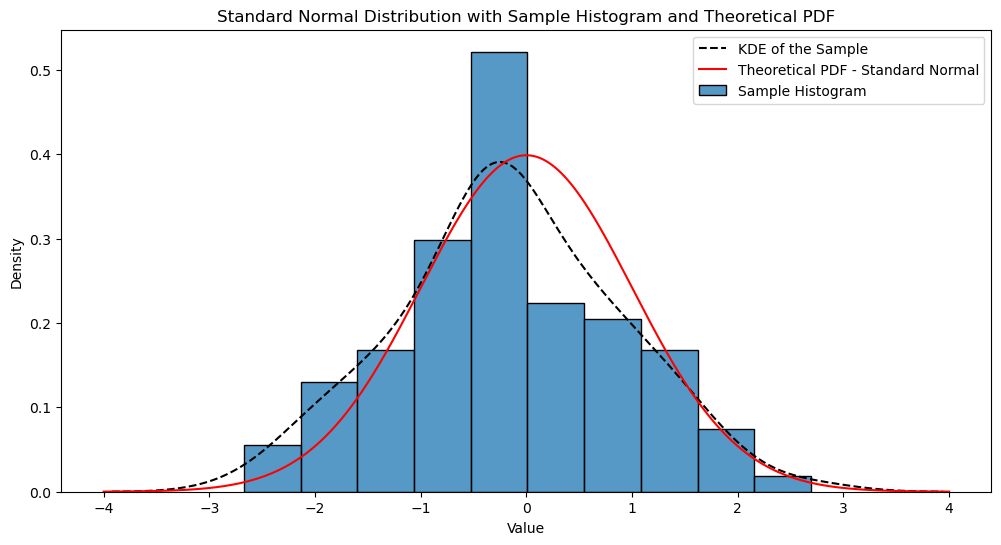

In [6]:
# Import of specific functions for generating indicators of the Normal distribution 
from scipy.stats import norm

# Generate and plot 100 random samples from a standard normal distribution
np.random.seed(150)
standard_normal = np.random.standard_normal(100)

# Categorize the standard normal data into 10 bins
categorized_data = pd.cut(standard_normal, 10)
# Create a frequency table (cross-tabulation) of the categorized data
frequency_table = pd.value_counts(categorized_data).sort_index()
df_frequency_table = pd.DataFrame({
    'Freq': frequency_table,
    'Weight': frequency_table / frequency_table.sum()
    }).reset_index().rename(columns={'index': 'Interval'})
# Calculate the PDF for the midpoint of each interval
df_frequency_table['Midpoint'] = df_frequency_table['Interval'].apply(lambda x: x.mid)
df_frequency_table['PDF'] = norm.pdf(df_frequency_table['Midpoint'])
# Calculate the CDF for the upper bound of each interval
df_frequency_table['CDF'] = norm.cdf(df_frequency_table['Interval'].apply(lambda x: x.right))
print("Frequency Table of Standard Normal Data Categorized into 10 Bins:")
print(df_frequency_table[['Interval', 'Freq', 'Weight', 'PDF', 'CDF']])

# Mean and standard deviation for the Standard normal distribution
mean = 0
std = 1
# Generate a range of x values from the mean and standard deviation
x_values = np.linspace(mean - 4*std, mean + 4*std, 1000)
# Calculate the PDF values for the x_values range
pdf_values = norm.pdf(x_values, loc=mean, scale=std)
# Create a combined plot
plt.figure(figsize=(12, 6))
# Histogram plot of the standard normal data with 10 bins
sns.histplot(standard_normal, bins=10, kde=False,
             stat='density', label='Sample Histogram')
# Create a Kernel Density Estimate (KDE) plot for the Smaple
sns.kdeplot(standard_normal, label='KDE of the Sample',
            color='black', linestyle='--')
# Plot the theoretical PDF line
plt.plot(x_values, pdf_values, color='red',
         label='Theoretical PDF - Standard Normal')
# Ploting
plt.title('Standard Normal Distribution with Sample Histogram and Theoretical PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


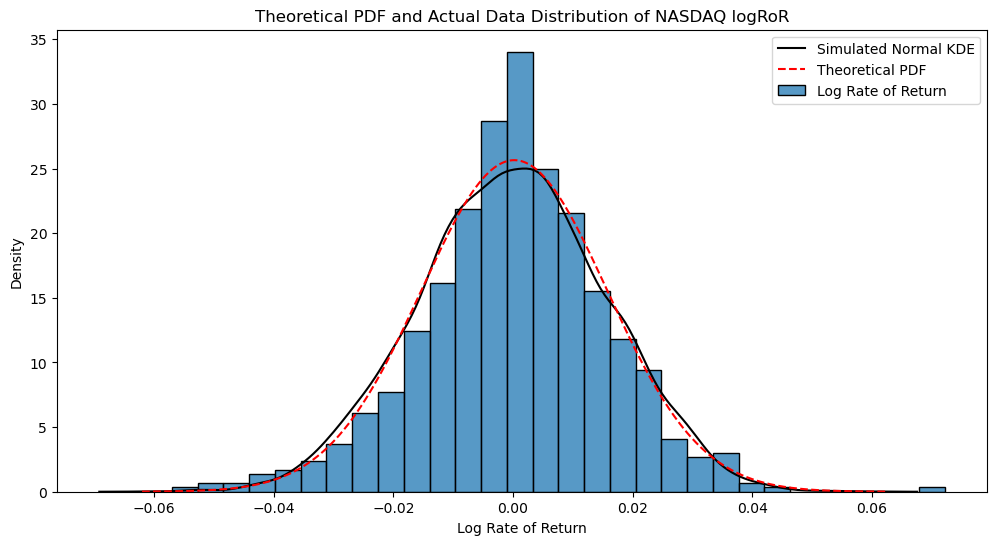

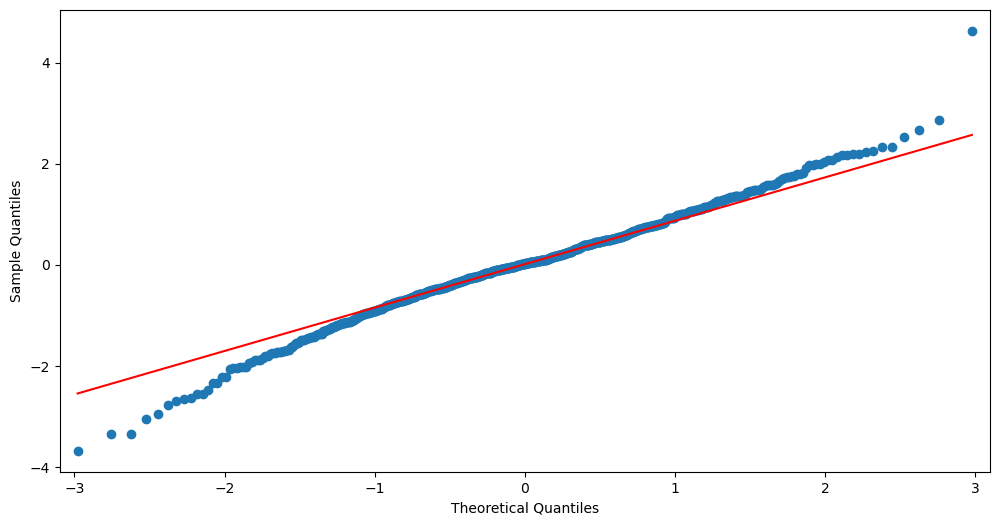

In [7]:
# Downloading historical data for the index
index_data = yf.download(index_ticker, start=start, end=end)
index_data['RoR'] = index_data['Adj Close'].pct_change()
index_data['logRoR'] = np.log(index_data['Adj Close'] /
                              index_data['Adj Close'].shift(1))
index_data.dropna(inplace=True)
mean = nasdaq_index['logRoR'].mean()
std = nasdaq_index['logRoR'].std()
# Create a BINS plot for NASDAQ's Log Rate of Return (logRoR) density
plt.figure(figsize=(12, 6))
sns.histplot(nasdaq_index['logRoR'], kde=False,
             stat='density', bins=30, label='Log Rate of Return')
# Create a simulated KDE plot based on NASDAQ logRoR statistics
simulated_data = np.random.normal(mean,std, 10000)
sns.kdeplot(simulated_data, color = 'black',
            label = 'Simulated Normal KDE')
# Generate a range of x values for Theoretical PDF
x_values = np.linspace(mean - 4*std, mean + 4*std, 1000)
# Calculate the PDF values for the x_values range
pdf_values = norm.pdf(x_values, loc=mean, scale=std)
# Plot the theoretical PDF line
plt.plot(x_values, pdf_values, color = 'red',
         linestyle = '--', label='Theoretical PDF')
# Plotting
plt.title('Theoretical PDF and Actual Data Distribution of NASDAQ logRoR')
plt.xlabel('Log Rate of Return')
plt.ylabel('Density')
plt.legend()

# Create the Q-Q plot
from statsmodels.graphics.api import qqplot
qqplot_fig = qqplot(nasdaq_index['logRoR'], line='q', fit=True)
qqplot_fig.set_size_inches(12, 6)

## Value at Risk


### VaR - Historical Method
This method uses historical returns to estimate the potential loss. It assumes that historical patterns will continue.

Historical Method.
With 95% confidence, the values will not exceed a loss of 2.66%.
With 95% confidence, the values will not exceed a loss of 3.52%.


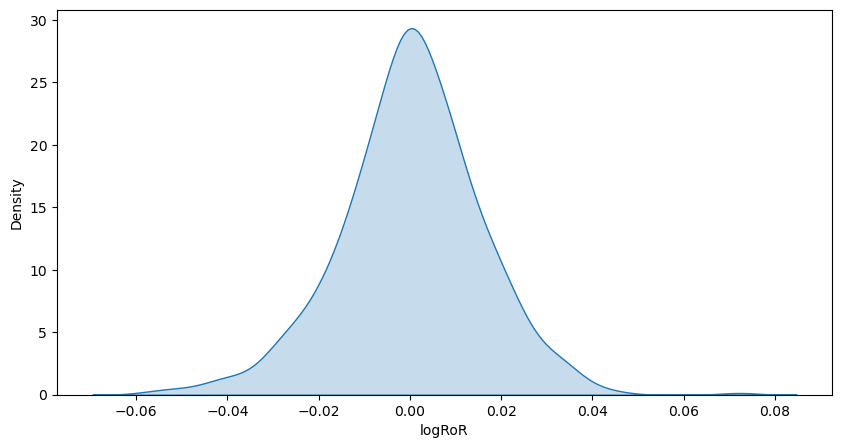

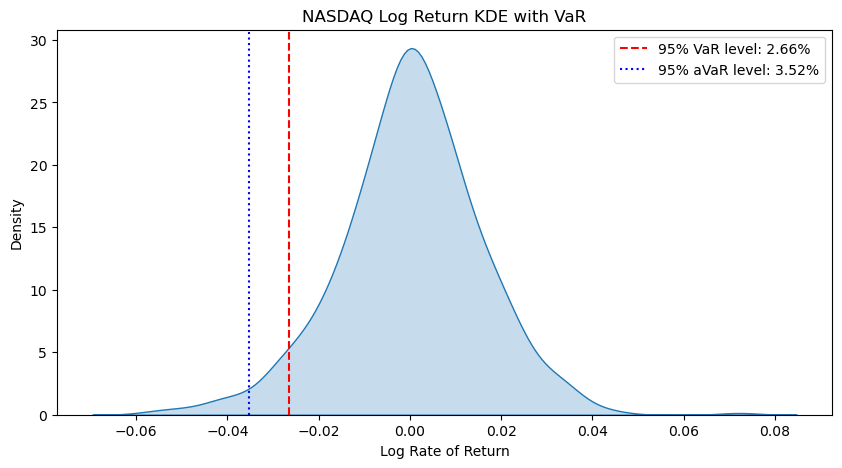

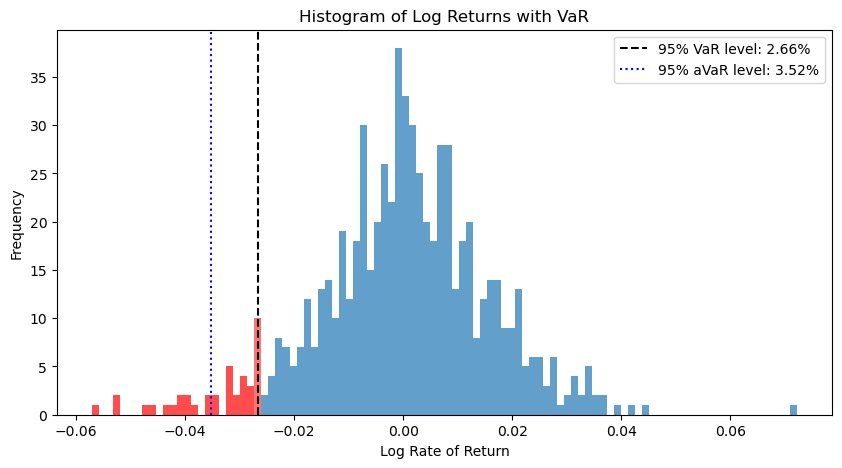

Historical Method.
With 95% confidence, the daily logRoR will not exceed a loss of 2.66%.
With 95% confidence, the average daily logRoR will not exceed a loss of 3.52%.


In [8]:
def calculating_VaRs_hist(data, confidence_level = 0.95,
                          out_text = False, out_viz = False):
    # Sort the log returns
    data_sorted = data.sort_values()
    # Calculate the VaR
    historical_var = data_sorted.quantile(1 - confidence_level)
    # Calculate the aVaR
    avar = data_sorted[data_sorted <= historical_var].mean()
    # Print the Value at Risk (VaR) result
    if out_text:
      print('Historical Method.')
      print(f'With 95% confidence, the values will not exceed a loss of {-historical_var * 100:.2f}%.')
      print(f'With 95% confidence, the values will not exceed a loss of {-avar * 100:.2f}%.')

    if out_viz:
      # Plot the KDE of the log returns
      plt.figure(figsize=(10, 5))
      sns.kdeplot(data_sorted, fill=True)
      plt.axvline(historical_var, color='r', linestyle='--', label=f'95% VaR level: {-historical_var * 100:.2f}%')
      plt.axvline(avar, color='b', linestyle=':', label=f'95% aVaR level: {-avar * 100:.2f}%')
      plt.title('NASDAQ Log Return KDE with VaR')
      plt.xlabel('Log Rate of Return')
      plt.ylabel('Density')
      plt.legend()
      plt.show()
      # Plot the histogram of the log returns with 100 bins
      plt.figure(figsize=(10, 5))
      n, bins, patches = plt.hist(data_sorted, bins=100, alpha=0.7)
      for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
          if rightside <= historical_var:
              patch.set_facecolor('red')
          if leftside < historical_var <= rightside:
              fraction = (historical_var - leftside) / (rightside - leftside)
              patch.set_facecolor('red')
              patch.set_alpha(fraction)
      plt.axvline(historical_var, color='k', linestyle='--',
                  label=f'95% VaR level: {-historical_var * 100:.2f}%')
      plt.axvline(avar, color='b', linestyle=':',
                  label=f'95% aVaR level: {-avar * 100:.2f}%')
      plt.title('Histogram of Log Returns with VaR')
      plt.xlabel('Log Rate of Return')
      plt.ylabel('Frequency')
      plt.legend()
      plt.show()

    # Return VaR and aVaR
    return({historical_var, avar})

# Input data: the nasdaq_index['logRoR'] Series is sorted by values from the worst to the best.
nasdaq_index_logRoR = nasdaq_index['logRoR'].sort_values()
# Plot the KDE of the log returns
plt.figure(figsize=(10, 5))
sns.kdeplot(nasdaq_index_logRoR, fill=True)
# Calculate the VaR and aVaR as previously described
confidence_level = 0.95
historical_var, avar = calculating_VaRs_hist(nasdaq_index_logRoR,
                                             confidence_level = confidence_level,
                                             out_text = True,
                                             out_viz = True)
# Print the Value at Risk (VaR) result
print('Historical Method.')
print(f'With 95% confidence, the daily logRoR will not exceed a loss of {-historical_var * 100:.2f}%.')
print(f'With 95% confidence, the average daily logRoR will not exceed a loss of {-avar * 100:.2f}%.')

### Variance-Covariance Method (Parametric Method)
This method assumes returns are normally distributed and uses the mean and standard deviation of returns.

Variance-Covariance Method.
With 95% confidence, the daily logRoR will not exceed a loss of 2.54%.
With 95% confidence, the average daily logRoR will not exceed a loss of 3.52%.


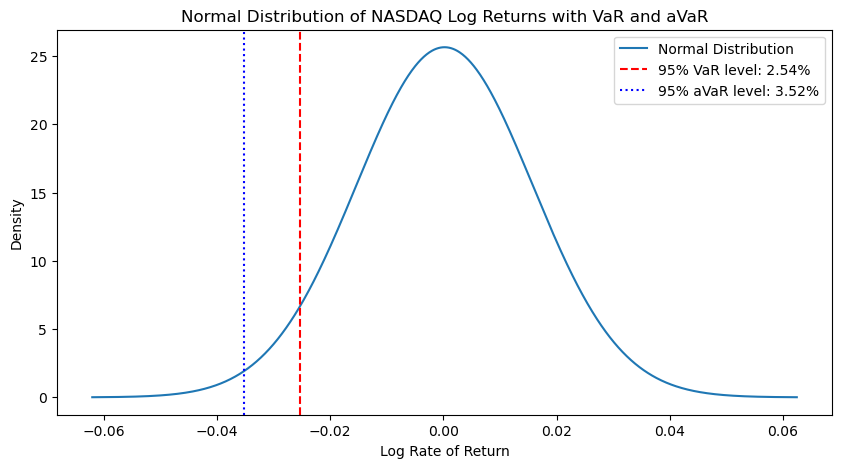

In [9]:
from scipy.stats import norm
# Input data: the nasdaq_index['logRoR'] Series is sorted by values from the worst to the best.
nasdaq_index_logRoR = nasdaq_index['logRoR'].sort_values()
mean_return = nasdaq_index_logRoR.mean()
std_return = nasdaq_index_logRoR.std()
# Assuming normal distribution and 95% confidence
confidence_level = 0.95
z_score = stats.norm.ppf(confidence_level)
variance_covar_var = mean_return - (std_return * z_score)
# Calculate the aVaR as previously described
avar = nasdaq_index_logRoR[nasdaq_index_logRoR <= historical_var].mean()
# Print the Value at Risk (VaR) result
print('Variance-Covariance Method.')
print(f'With 95% confidence, the daily logRoR will not exceed a loss of {-variance_covar_var * 100:.2f}%.')
print(f'With 95% confidence, the average daily logRoR will not exceed a loss of {-avar * 100:.2f}%.')
# Generate a range of x values from the mean and standard deviation
x_values = np.linspace(mean_return - 4*std_return, mean_return + 4*std_return, 1000)
# Calculate the PDF values for the x_values range
pdf_values = norm.pdf(x_values, loc=mean_return, scale=std_return)
# Plot the normal distribution PDF
plt.figure(figsize=(10, 5))
plt.plot(x_values, pdf_values, label='Normal Distribution')
# Plot a vertical line for the VaR and aVaR on the PDF plot
plt.axvline(variance_covar_var, color='r', linestyle='--', label=f'95% VaR level: {-variance_covar_var * 100:.2f}%')
plt.axvline(avar, color='b', linestyle=':', label=f'95% aVaR level: {-avar * 100:.2f}%')
# Add labels and legend to the plot
plt.title('Normal Distribution of NASDAQ Log Returns with VaR and aVaR')
plt.xlabel('Log Rate of Return')
plt.ylabel('Density')
plt.legend()
# Show the plot
plt.show()

### VaR and aVaR for risk of assets comparison

In [10]:
VaRs = pd.DataFrame()
for asset in nasdaq_assets['logRoR'].columns:
    # Get VaR and aVaR for the current asset by predefined function
    historical_var, avar = calculating_VaRs_hist(nasdaq_assets['logRoR'][asset])
    # Store the results in the DataFrame
    VaRs.loc['VaR', asset] = -historical_var  # Convert to positive percentage
    VaRs.loc['aVaR', asset] = -avar  # Convert to positive percentage
VaRs.transpose().sort_values(['VaR']).to_excel('table81.xlsx')
VaRs.transpose().sort_values(['VaR'])

,VaR,aVaR
MDLZ,0.017513,0.025973
KDP,0.018124,0.026834
AMGN,0.019669,0.027976
HON,0.021081,0.030964
VRSK,0.023683,0.035610
AZN,0.025264,0.035575
PCAR,0.025834,0.032437
DLTR,0.027567,0.055259
SBUX,0.028031,0.042168
CSGP,0.028851,0.049055


## Monte-Carlo Method

### Geometric Brownian Motion Method for Price Prediction

$$
S(t) = S(0) e^{ (\mu - \frac{\sigma^2}{2})t + \sigma W_t }
$$
$$
W_t \sim N(0, t) \ \forall \ t \geq 0.
$$

where:
- $ S(t) $ is the stock price at time t.
- $ S(0) $ is the initial stock price.
- $ \mu $ is the mean coefficient.
- $ \sigma $ is the volatility coefficient.
- $ W(t) $ is a Standard Brownian Motion or Wiener proces.

[Geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_10939/166731963.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data[-1]


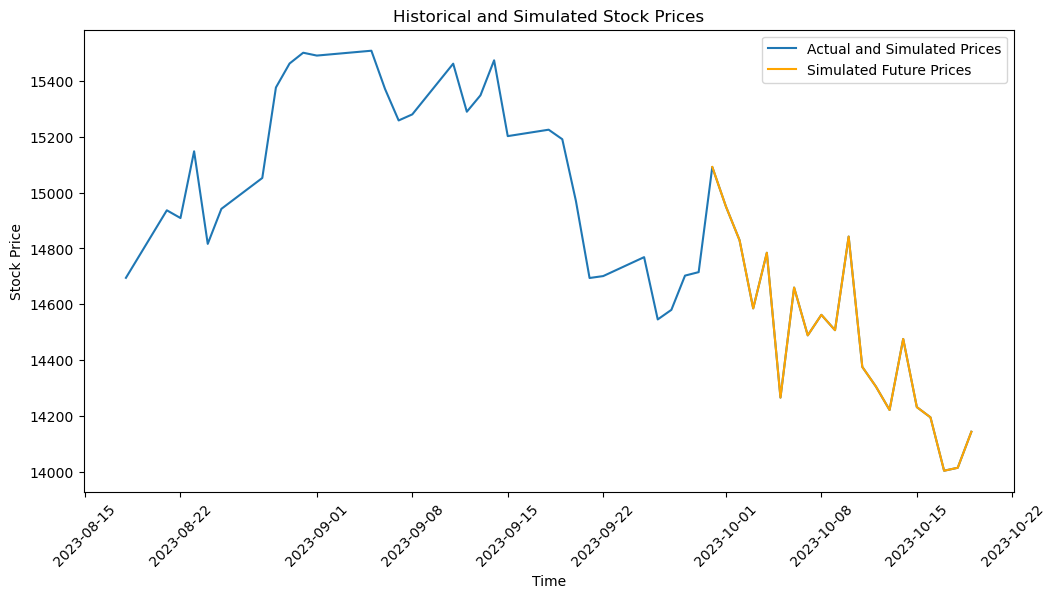

In [11]:
# Gtting input data
log_returns = nasdaq_index['logRoR']
data = nasdaq_index['Adj Close']
# Estimate parameters
mu = log_returns.mean()
sigma = log_returns.std()
# Time horizon in days for prediction
T_pred = 20
# Number of historical days to display
T_real = 30
# Number of intervals for simulation
N = T_pred
# Starting stock price (last available real data)
S0 = data[-1]
# Generate random Brownian Motion for prediction
np.random.seed(1)
random_walk = np.random.standard_normal(size=N)
# Assuming daily time steps
brownian_motion = np.cumsum(random_walk) * np.sqrt(1.) 
# Simulate future price path
future_prices = S0 * np.exp((mu - 0.5 * sigma**2) *
                            np.linspace(0, T_pred, N) +
                            sigma * brownian_motion)
# Combine historical and future data for vizualiztion
historical_dates = data.index[-T_real:]
future_dates = pd.date_range(start=data.index[-1],
                             periods=N+1, freq='D')[1:]
all_dates = historical_dates.union(future_dates)
all_prices = pd.concat([data[-T_real:],
                        pd.Series(future_prices,
                                  index=future_dates)])
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_prices,
         label='Actual and Simulated Prices')
plt.plot(future_dates, future_prices, color='orange',
         label='Simulated Future Prices')
plt.title('Historical and Simulated Stock Prices')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.legend()
plt.show()

/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_10939/2891490524.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data[-1]


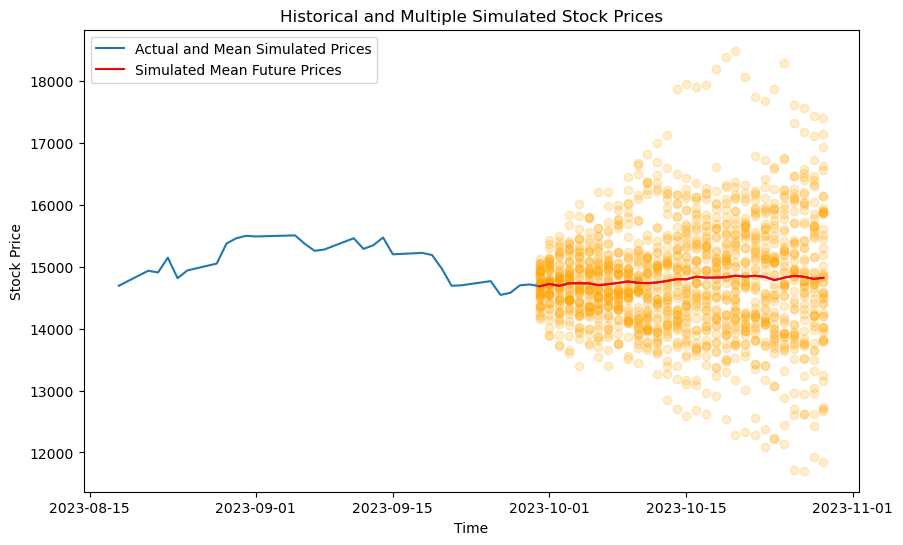

In [12]:
# Getting input Data
log_returns = nasdaq_index['logRoR']
data = nasdaq_index['Adj Close']
# Estimate parameters
mu = log_returns.mean()
sigma = log_returns.std()
# Time horizon in days for prediction
T_pred = 30
# Number of simulations
T_sim = 50
# Number of historical days to display
T_real = 30
# Number of intervals for simulation
N = T_pred
# Starting stock price (last available real data)
S0 = data[-1]
# Array to store simulation results
simulation_results = np.zeros((T_sim, N))
np.random.seed(11)
# Run multiple simulations
for i in range(T_sim):
    random_walk = np.random.standard_normal(size=N)
    # Assuming daily time steps
    brownian_motion = np.cumsum(random_walk) * np.sqrt(1.)
    simulation_results[i, :] = S0 * np.exp((mu - 0.5 * sigma**2) *
                               np.linspace(0, T_pred, N) +
                               sigma * brownian_motion)
# Calculate the mean of simulations
mean_simulation = simulation_results.mean(axis=0)
# Historical dates and future dates
historical_dates = data.index[-T_real:]
future_dates = pd.date_range(start=data.index[-1],
                             periods=N+1, freq='D')[1:]
# Combine historical and future data for plotting
combined_dates = historical_dates.union(future_dates)
combined_prices = pd.concat([data[-T_real:],
                             pd.Series(mean_simulation,
                                       index=future_dates)])
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(combined_dates, combined_prices,
         label='Actual and Mean Simulated Prices')
plt.plot(future_dates, mean_simulation, color='red',
         label='Simulated Mean Future Prices', linestyle='-')
# Plot each simulation
for sim in simulation_results:
    plt.scatter(future_dates, sim, color='orange', alpha=0.2)
plt.title('Historical and Multiple Simulated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### VaRs by Monte-Carlo Assessment

Historical Method.
With 95% confidence, the values will not exceed a loss of 2.51%.
With 95% confidence, the values will not exceed a loss of 3.17%.


/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_10939/1833319797.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = data[-1]


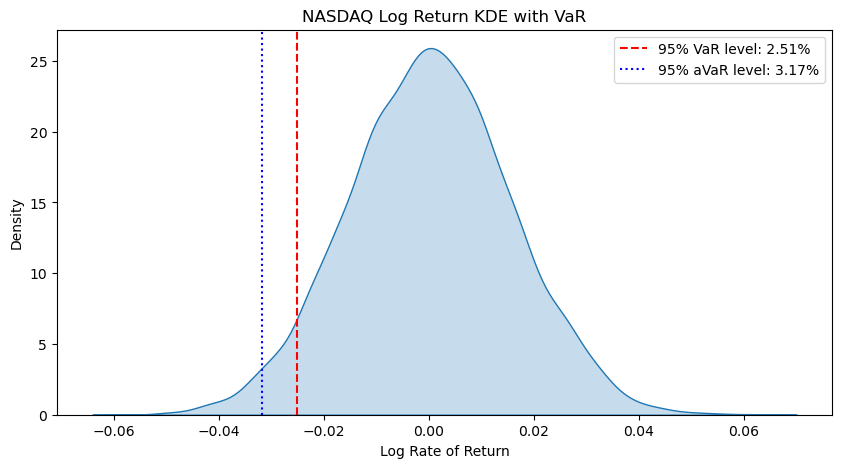

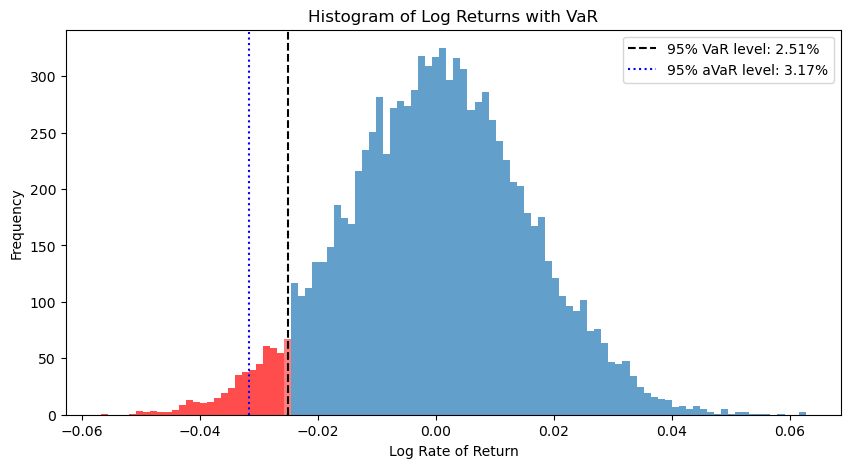

In [13]:
# Getting Input data
log_returns = nasdaq_index['logRoR']
data = nasdaq_index['Adj Close']
# Estimate parameters
mu = log_returns.mean()
sigma = log_returns.std()
# Time horizon in days for prediction
T_pred = 10000
# Number of intervals for simulation
N = T_pred
# Starting stock price (last available real data)
S0 = data[-1]
# Generate random Brownian Motion for prediction
np.random.seed(1)
random_walk = np.random.standard_normal(size=N)
brownian_motion = np.cumsum(random_walk) * np.sqrt(1.)
# Simulate future price path
future_prices = S0 * np.exp((mu - 0.5 * sigma**2) *
                      np.linspace(0, T_pred, N) +
                      sigma * brownian_motion)
# Combine historical and future data
historical_dates = data.index[-T_real:]
future_dates = pd.date_range(start=data.index[-1],
                             periods=N+1, freq='D')[1:]
# Estimation VaR and aVaR based on historical method
# calculating_VaRs_hist() function is defined in the code Appendix.
# The Function returns VaR and aVaR from pd.DataFame of the asset prices
x = pd.Series(future_prices)
logx = (np.log(x) - np.log(x).shift(1)).dropna()
var, avar = calculating_VaRs_hist(logx, confidence_level = 0.95,
                          out_text = True, out_viz = True)

### Derivatives: Volumes and Risk (Index, ETS, Futures of SP500)

In [14]:
'''
S&P 500 Securities Tickers
^GSPC - This is the ticker symbol for the S&P 500 Index.
        It represents the stock market index based on the market capitalizations of 500
        large companies listed on stock exchanges in the United States.
ES=F  - This ticker symbol represents the S&P 500 Futures. Futures are financial
        contracts obligating the buyer to purchase an asset (like the S&P 500) at
        a predetermined future date and price. The 'ES=F' is the futures contract for
        the S&P 500 on the Chicago Mercantile Exchange (CME).
SPY   - This is the ticker symbol for the SPDR S&P 500 ETF Trust, an exchange-traded
        fund that tracks the S&P 500 stock market index. This ETF provides investors with an opportunity
        to have exposure to the performance of the S&P 500 index.
'''
# Download data for the specified tickers and date range
SP500_secirities = yf.download(['^GSPC', 'ES=F', 'SPY'], start = start, end = end)

[*********************100%%**********************]  3 of 3 completed


In [15]:
# Average Volumes
# Download volume data
volume_data = SP500_secirities['Volume'] / SP500_secirities['Adj Close']

# Calculate average volumes
average_volumes = volume_data.mean()

print(average_volumes)

Ticker
ES=F     3.907712e+02
SPY      2.075257e+05
^GSPC    1.055412e+06
dtype: float64


In [16]:
# Calculating Mean logRoR
sp500_data = SP500_secirities['Adj Close']

log_returns = np.log(sp500_data / sp500_data.shift(1))
mean_log_returns = log_returns.mean()

print(mean_log_returns * 100)

Ticker
ES=F     0.022974
SPY      0.027294
^GSPC    0.021382
dtype: float64


In [17]:
# Calculating VaR and eVaR
def calculate_var(series, confidence_level=0.95):
    sorted_returns = series.dropna().sort_values()
    var = sorted_returns.quantile(1 - confidence_level)
    avar = sorted_returns[sorted_returns <= var].mean()
    return -var, -avar  # Return positive values

# Calculate VaR and eVaR for each security
var_results = {ticker: calculate_var(log_returns[ticker]) for ticker in log_returns.columns}

# Convert results to DataFrame for better presentation
var_df = pd.DataFrame(var_results, index=['VaR', 'eVaR']).T

# Combine all analyses into one DataFrame
analysis_df = pd.DataFrame({
    'Average Volume': average_volumes,
    'Mean Log Return': mean_log_returns,
}).join(var_df)

print(analysis_df)

        Average Volume  Mean Log Return       VaR      eVaR
Ticker                                                     
ES=F      3.907712e+02         0.000230  0.018727  0.026483
SPY       2.075257e+05         0.000273  0.018435  0.026324
^GSPC     1.055412e+06         0.000214  0.018613  0.026375


### Option Pricing: GBM and the Black-Scholes formula
CALL

$$
\textbf{C} = SN(d_1) - Ke^{-r(T-t)}N(d_2)
$$

PUT

$$
\textbf{C} = Ke^{-r(T-t)}N(-d_2) - SN(-d_1)
$$

where
$$
d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{sd^2}{2})(T-t)}{s \cdot \sqrt{T-t}}
$$
$$
d_2 = d_1 - s \cdot \sqrt{T-t} = \frac{\ln(\frac{S}{K}) + (r - \frac{sd^2}{2})(T-t)}{s \cdot \sqrt{T-t}}
$$


[Black–Scholes model Wiki](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)

In [18]:
# Function to calculate Black-Scholes option price
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    return price

# Sample inputs - you'll need to replace these with real values
S = 150  # Current stock price
K = 100  # Strike price
T = 1    # Time to expiration in years or (T-t) in the BS formula
r = 0.01 # Risk-free rate
sigma = 0.25 # Volatility
# Calculate and print option price
call_price = black_scholes(S, K, T, r, sigma, 'call')
put_price = black_scholes(S, K, T, r, sigma, 'put')
print(f"Call Option Price: {call_price}")
print(f"Put Option Price: {put_price}")

Call Option Price: 51.60253352585224
Put Option Price: 0.607516900769026


In [19]:
# Set to True to fetch data online, False to use local CSV files
online_data = False
# Check if we are using online data
if online_data:
  # Initialize a Ticker object
  ticker = yf.Ticker('AAPL')
  # Print the available expiration dates for options
  print(ticker.options)
  # Load current call options data
  e_date_c = ticker.options[0]
  calls = ticker.option_chain(e_date_c).calls
  calls.to_csv(f'calls_{e_date_c}.csv')

  # Load current put options data
  e_date_p = ticker.options[3]
  puts = ticker.option_chain(e_date_p).puts
  puts.to_csv(f'puts_{e_date_p}.csv')
else:
  # If offline, load call options data from a local CSV file
  calls = pd.read_csv('calls_2024-01-12.csv')
  e_date_c = '2024-01-12'  # Expiration date corresponding to the call data

  # If offline, load put options data from a local CSV file
  puts = pd.read_csv('puts_2024-02-02.csv')
  e_date_p = '2024-02-02'  # Expiration date corresponding to the put data

# Print the expiration date and the first few rows of the call options data
print(f"Expiration date for calls: {e_date_c}")
print(calls.head())
# Print the expiration date and the first few rows of the put options data
print(f"Expiration date for puts: {e_date_p}")
print(puts.head())

FileNotFoundError: [Errno 2] No such file or directory: 'calls_2024-01-12.csv'

In [ ]:
ticker = yf.Ticker('AAPL')
print(ticker.options)
# Uncommnet to use up-to-date data
online_data = False
if online_data:
  # load current call options data
  e_date_c = ticker.options[0]
  calls = ticker.option_chain(e_date_c).calls
  calls.to_csv(f'calls_{e_date_c}.csv')
  # load current puts options data
  e_date_p = ticker.options[3]
  puts = ticker.option_chain(e_date_p).puts
  puts.to_csv(f'puts_{e_date_p}.csv')
else:
  calls = pd.read_csv('calls_2024-01-12.csv')
  e_date_c = '2024-01-12'
  puts = pd.read_csv('puts_2024-02-02.csv')
  e_date_p = '2024-02-02'
print(e_date_c)
print(calls.head())
print(e_date_p)
print(puts.head())

('2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-09-20', '2024-12-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16')
2024-01-12
   Unnamed: 0       contractSymbol              lastTradeDate  strike  \
0           0  AAPL240112C00060000  2023-12-21 16:40:40+00:00    60.0   
1           1  AAPL240112C00075000  2024-01-04 18:15:33+00:00    75.0   
2           2  AAPL240112C00085000  2023-12-08 18:02:53+00:00    85.0   
3           3  AAPL240112C00125000  2024-01-05 20:16:50+00:00   125.0   
4           4  AAPL240112C00130000  2024-01-05 18:22:07+00:00   130.0   

   lastPrice     bid     ask     change  percentChange  volume  openInterest  \
0     134.90  120.35  122.10   0.000000       0.000000     NaN             2   
1     106.31  105.35  107.25  -1.380005      -1.281460     1.0             1   
2     110.78   95.40   96.70   0.000000       0.000000   

**Options Data Description from the Yahoo Finance **

0: This is an index column.

contractSymbol: The unique identifier for the option contract, typically including the underlying stock ticker, expiration date, call/put indicator, and strike price.

lastTradeDate: The date and time of the last trade of this option.

strike: The strike price of the option, i.e., the price at which the option can be exercised.

lastPrice: The last traded price of the option.

bid: The current bid price for the option.

ask: The current ask price for the option.

change: The change in the option's price from the previous day.

percentChange: The percentage change in the option's price from the previous day.

volume: The number of contracts traded in the last trading session.

openInterest: The total number of outstanding option contracts that have not been settled.

impliedVolatility: The option's implied volatility, a measure of expected future volatility inferred from its market price.

inTheMoney: A Boolean indicating whether the option is in the money (true) or not (false).

contractSize: The size of the option contract, usually 'REGULAR' for standard options.

currency: The currency in which the option is priced, here 'USD'.

In [ ]:
# Ticker symbol for asset
ticker = yf.Ticker('AAPL')
# Get data for call options
expiration_date = pd.to_datetime(e_date_c, utc=True)
now_day = expiration_date - 5 * pd.tseries.offsets.BDay()
now_text = str(now_day).split(' ')[0]
option = calls.iloc[10]
# Get the current price of the basic asset
current_price = ticker.history()['Close'].loc[now_text]
# Download the risk-free rate from a relevant U.S. Treasury yield
# ^IRX is the 13-week Treasury Bill
treasury_ticker = yf.Ticker("^IRX")
# Convert to a decimal
risk_free_rate = treasury_ticker.history()['Close'].loc[now_text] / 100
# Get option contract data
strike_price = option['strike']
# Convert to a decimal
implied_volatility = option['impliedVolatility'] / 100
# Calculate date for option expiration in years scale
time_to_expiration = (expiration_date - now_day).days / 365.0
# Calculate Black-Scholes price
bs_price = black_scholes(current_price, strike_price,
                         time_to_expiration, risk_free_rate,
                         implied_volatility, option_type='call')
print(f'Option expiration date is {e_date_c}')
print(f"Black-Scholes Call Option Price on {now_text} is {bs_price:.2f}")
print('\n', option)

Option expiration date is 2024-01-12
Black-Scholes Call Option Price on 2024-01-05 is 21.34

 Unnamed: 0                                  10
contractSymbol             AAPL240112C00160000
lastTradeDate        2024-01-05 20:58:30+00:00
strike                                   160.0
lastPrice                                21.36
bid                                      20.55
ask                                      22.15
change                               -0.459999
percentChange                        -2.108154
volume                                   115.0
openInterest                                86
impliedVolatility                     0.540044
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
Name: 10, dtype: object


In [ ]:
# Ticker symbol for asset
ticker = yf.Ticker('AAPL')
# Get data for call options
expiration_date = pd.to_datetime(e_date_p, utc=True)
now_day = expiration_date - 20 * pd.tseries.offsets.BDay()
now_text = str(now_day).split(' ')[0]
option = puts.iloc[-3]
# Get the current price of the basic asset
current_price = ticker.history()['Close'].loc[now_text]
# Download the risk-free rate from a relevant U.S. Treasury yield
# ^IRX is the 13-week Treasury Bill
treasury_ticker = yf.Ticker("^IRX")
# Convert to a decimal
risk_free_rate = treasury_ticker.history()['Close'].loc[now_text] / 100
# Get option contract data
strike_price = option['strike']
 # Convert to a decimal
implied_volatility = option['impliedVolatility'] / 100
# Calculate date for option expiration in years scale
time_to_expiration = (expiration_date - now_day).days / 365.0
# Calculate Black-Scholes price
bs_price = black_scholes(current_price, strike_price,
                         time_to_expiration, risk_free_rate,
                         implied_volatility, option_type='put')
print(f'Option expiration date is {e_date_p}')
print(f"Black-Scholes Put Option Price on {now_text} is {bs_price:.2f}")
print('\n', option)

Option expiration date is 2024-02-02
Black-Scholes Put Option Price on 2024-01-05 is 27.98

 Unnamed: 0                                  18
contractSymbol             AAPL240202P00210000
lastTradeDate        2024-01-02 14:48:19+00:00
strike                                   210.0
lastPrice                                 23.4
bid                                       27.5
ask                                       30.3
change                                     0.0
percentChange                              0.0
volume                                     1.0
openInterest                                 0
impliedVolatility                     0.465337
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
Name: 18, dtype: object


## ARCH and GARCH models

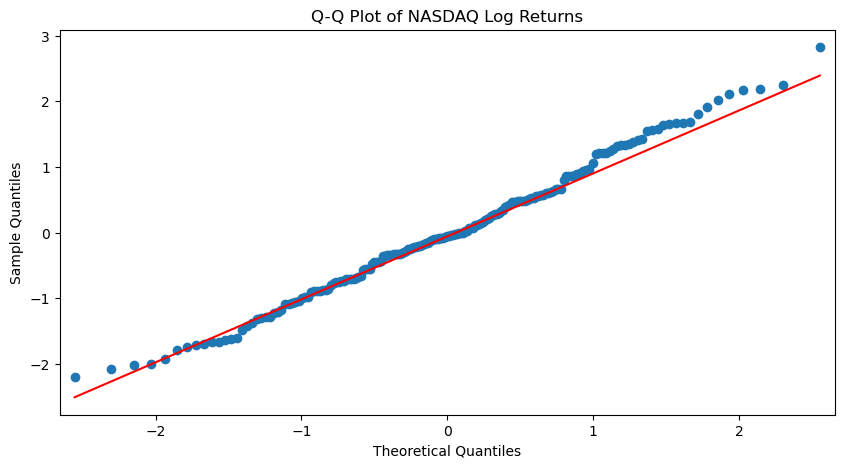

Jarque-Bera test statistic: 1.536940091045956
p-value: 0.4637219994058751
The series is normally distributed according to the Jarque-Bera test.
ADF Statistic: -10.599293729783524
p-value: 6.231097281689446e-19
The series is stationary.


In [31]:
from scipy import stats
# Stage 1: Data Preparation
# Extract log returns and drop any missing values
data = nasdaq_index['logRoR']['2023'].dropna().rename('NASDAQ')
# Create a Q-Q (quantile-quantile) plot 
# to check the normality of the distribution
qqplot_fig = qqplot(data, line='q', fit=True)
qqplot_fig.set_size_inches(10, 5)
plt.title('Q-Q Plot of NASDAQ Log Returns')
plt.show()
# Perform the Jarque-Bera test
# Null hypothesis (H0): The data is normally distributed
# If the p-value is less than 
# the significance level (e.g., 0.05), we reject H0
jb_test_statistic, jb_p_value = stats.jarque_bera(data)
print(f"Jarque-Bera test statistic: {jb_test_statistic}")
print(f"p-value: {jb_p_value}")
is_normal = jb_p_value > 0.05
print("The series is",
      f"{'normally distributed' if is_normal else 'not normally distributed'}",
      "according to the Jarque-Bera test.")
# Perform the Augmented Dickey-Fuller test to check the stationarity of the data
adf_result = adfuller(data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
is_stationary = adf_result[1] < 0.05
print(f"The series is {'stationary' if is_stationary else 'non-stationary'}.")

In [32]:
# Stage 2: Model Specification
from arch import arch_model
# Show the arch_model() arguments:
# see details here: 
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
help(arch_model)
# Specify the GARCH model with an autoregressive 
# mean structure including one lag
model = arch_model(y=data, 
                   # Specify the volatility model to be GARCH
                   vol='GARCH',   
                   # Specify the mean model to be autoregressive 
                   mean='AR',
                   # Use one lag in the autoregressive model          
                   lags=1,  
                   # ARCH component order             
                   p=1,   
                   # GARCH component order               
                   q=1,   
                   # Do not automatically rescale data               
                   rescale=False,    
                   # Assume a normal distribution for the error term   
                   dist='normal')        
# Set a date to split the data into the in-sample 
# for fitting and out-of-sample for forecasting
split_date = datetime(2023, 9, 1)
# Fit the model up to the split_date
# Frequency of output during estimation
model_fit = model.fit(update_freq=10,
                      last_obs=split_date)
# Print the model summary
model_fit.summary()

Help on function arch_model in module arch.univariate.mean:

arch_model(y: 'ArrayLike | None', x: 'ArrayLike2D | None' = None, mean: "Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero']" = 'Constant', lags: 'None | int | list[int] | Int32Array | Int64Array' = 0, vol: "Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']" = 'GARCH', p: 'int | list[int]' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0, dist: "Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']" = 'normal', hold_back: 'int | None' = None, rescale: 'bool | None' = None) -> 'HARX'
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : ndarray, DataFrame, optional
        Exogenous regressors.  Ignored if model does not permit exogenous
        regressors.
    mean : str, optional
        Name of the mean model.  Curr

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 NASDAQ   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.006
Vol Model:                      GARCH   Log-Likelihood:                499.674
Distribution:                  Normal   AIC:                          -989.348
Method:            Maximum Likelihood   BIC:                          -973.788
                                        No. Observations:                  166
Date:                Wed, Jun 12 2024   Df Residuals:                      164
Time:                        18:27:06   Df Model:                            2
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      2.0103e-03  1.869e-04     10.759  5.397e-27 [1.644e-03,2.377e-03]
NASDAQ[1]      0.0166  6.577e-02      0.252      0.801     [ -0.112,  0.145]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.9081e-06  3.470e-11  8.381e+04      0.000  [2.908e-06,2.908e-06]
alpha[1]   9.9985e-03  2.460e-02      0.406      0.684 [-3.822e-02,5.822e-02]
beta[1]        0.9698  2.018e-02     48.063      0.000      [  0.930,  1.009]
=============================================================================

Covariance estimator: robust
"""

In [27]:
help(arch_model)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: 'ArrayLike | None', x: 'ArrayLike2D | None' = None, mean: "Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero']" = 'Constant', lags: 'None | int | list[int] | Int32Array | Int64Array' = 0, vol: "Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH', 'FIGARCH']" = 'GARCH', p: 'int | list[int]' = 1, o: 'int' = 0, q: 'int' = 1, power: 'float' = 2.0, dist: "Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']" = 'normal', hold_back: 'int | None' = None, rescale: 'bool | None' = None) -> 'HARX'
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : ndarray, DataFrame, optional
        Exogenous regressors.  Ignored if model does not permit exogenous
        regressors.
    mean : str, optional
        Name of the mean model.  Curr

In [21]:
# Stage 3. Model Fitting and Diagnostic
model = arch_model(data, vol='GARCH',
                   mean = 'Zero',
                   p = 1,
                   q = 1,
                   rescale=False,
                   dist='normal')

split_date = datetime(2023,9,1)
model_fit = model.fit(update_freq=10,
                      last_obs=split_date)
model_fit.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -500.2711007397694
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 NASDAQ   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                500.271
Distribution:                  Normal   AIC:                          -994.542
Method:            Maximum Likelihood   BIC:                          -985.188
                                        No. Observations:                  167
Date:                Wed, Jun 12 2024   Df Residuals:                      167
Time:                        11:35:07   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.9864e-06  1.378e-10  2.167e+04      0.000 [2.986e-06,2.987e-06]
alpha[1]       0.0100  1.685e-03      5.936  2.919e-09 [6.698e-03,1.330e-02]
beta[1]        0.9700  4.008e-03    242.033      0.000     [  0.962,  0.978]
============================================================================

Covariance estimator: robust
"""

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/arch/univariate/base.py:1613: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plot_fn(x_values, y_values, linestyle="-", marker="")
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/arch/univariate/base.py:1628: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  line = plot_fn(temp_x, temp_y, linewidth=3, linestyle="-", marker="")


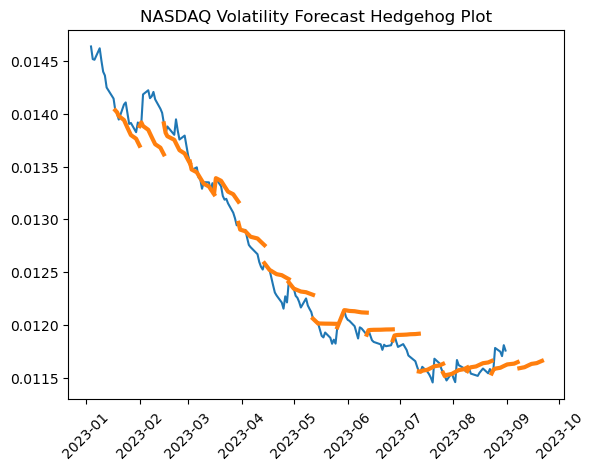

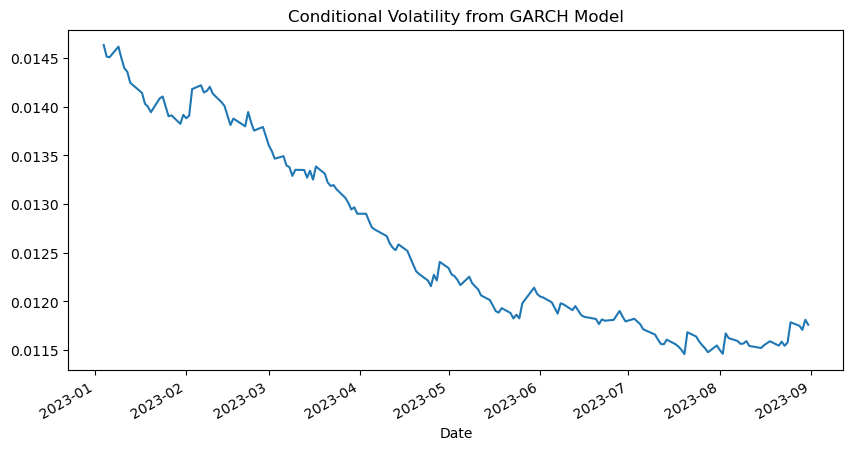

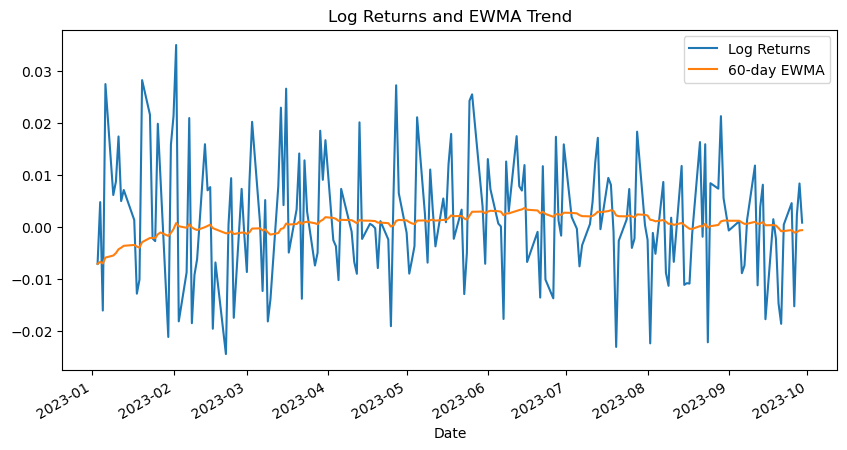

In [33]:
# Stage 4: Interpretations
# Generate a hedgehog plot of 
# the volatility forecast by the model
model_fit.hedgehog_plot()
plt.xticks(rotation=45)
plt.title('NASDAQ Volatility Forecast Hedgehog Plot')
plt.show()
# Plot the conditional volatility from the model
plt.figure(figsize=(10, 5))
model_fit.conditional_volatility.plot()
plt.title('Conditional Volatility from GARCH Model')  
plt.show()
# Plot the actual log returns alongside the exponentially 
# weighted moving average (EWMA). 
plt.figure(figsize=(10, 5))
data.plot(label='Log Returns')  
data.ewm(span=60, 
         adjust=False).mean().plot(label='60-day EWMA')  
plt.title('Log Returns and EWMA Trend')  
plt.legend()  
plt.show()

In [23]:
# Stage 5: Making Predictions
# Forecast the future volatility over a horizon of 5 days,
# starting from the split date
test_forecast = model_fit.forecast(horizon=5,
                                   start=split_date,
                                   reindex=False)
# The forecast returns variance, so we take the square root
# to get the standard deviation, which represents volatility
predicted_volatility = np.sqrt(test_forecast.variance.dropna())
# Printing the predicted volatility
print("Predicted Volatility:")
print(predicted_volatility)

Predicted Volatility:
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2023-09-01  0.011824  0.011832  0.011840  0.011848  0.011855
2023-09-05  0.011773  0.011782  0.011791  0.011800  0.011808
2023-09-06  0.011757  0.011766  0.011775  0.011785  0.011793
2023-09-07  0.011731  0.011741  0.011750  0.011760  0.011769
2023-09-08  0.011683  0.011694  0.011704  0.011715  0.011725
2023-09-11  0.011695  0.011706  0.011716  0.011726  0.011737
2023-09-12  0.011701  0.011711  0.011722  0.011732  0.011742
2023-09-13  0.011659  0.011671  0.011682  0.011693  0.011704
2023-09-14  0.011641  0.011653  0.011664  0.011676  0.011687
2023-09-15  0.011729  0.011739  0.011748  0.011758  0.011767
2023-09-18  0.011681  0.011692  0.011703  0.011713  0.011724
2023-09-19  0.011636  0.011648  0.011659  0.011671  0.011682
2023-09-20  0.011682  0.011693  0.011704  0.011714  0.011724
2023-09-21  0.011782  0.011791  0.011799  0.011808  0.011816
20

In [ ]:
## VAR by GARCH.
# https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#Value-at-Risk-Forecasting

# Chapter 8
## &copy; Dr. Dmytro Zherlitsyn, 2024 <br>
## &copy; BPB Publications, 2024